# Study 2, RQ1 Analysis

# Setup

In [167]:
import json
import copy
import os

import pandas as pd

import statistics as s
from bert_score import score
from tqdm.notebook import tqdm

import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Helper functions

In [197]:
def compute_bertscore_with_list(
    data_input,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
    rescale_with_baseline=False,
):
    # make a deepcopy
    data_input = copy.deepcopy(data_input)

    # construct input to sentence bert [[list of captions], [[references], references]]
    candidates = {}
    references = []
    for image in data_input:
        curr_references = [
            caption["caption"]
            for caption in image["human_captions"]
            if caption["caption"]
            != "Quality issues are too severe to recognize visual content."
        ]

        for model in image["model_captions"]:
            curr_model_name = model["model_name"]

            # compute scores for current model
            curr_candidate = model["caption"]
            if curr_model_name not in candidates:
                candidates[curr_model_name] = [curr_candidate]
            else:
                candidates[curr_model_name].append(curr_candidate)

        references.append(curr_references)

    bertscore_output_per_model = {}
    for model_name in candidates.keys():
        P_lst, R_lst, F1_lst = score(
            candidates[model_name],
            references,
            model_type=model_type,
            lang=lang,
            rescale_with_baseline=rescale_with_baseline,
        )
        bertscore_output_per_model[model_name] = {
            "precision": P_lst,
            "recall": R_lst,
            "f1": F1_lst,
        }

    # convert lists into formatted output for data_input
    bertscore_outputs = {}
    for model_name in candidates.keys():
        curr_output = []
        for P, R, F1 in zip(
            bertscore_output_per_model[model_name]["precision"],
            bertscore_output_per_model[model_name]["recall"],
            bertscore_output_per_model[model_name]["f1"],
        ):
            curr_output.append(
                {
                    "scores": {
                        "precision": float(P),
                        "recall": float(R),
                        "f1": float(F1),
                    }
                }
            )
        bertscore_outputs[model_name] = curr_output

    # attach bertscore outputs to data_input
    for index, image in enumerate(data_input):
        curr_output = {}
        for model_name in bertscore_outputs.keys():
            curr_output[model_name] = bertscore_outputs[model_name][index]
        if "evaluation" not in image:
            image["evaluation"] = {}
        image["evaluation"]["bertscore"] = curr_output

    return data_input

In [198]:
def compute_average_metrics_bertscore(dataset):
    """
    Computes average precision, recall, and f1 for BERTScore for each model.
    """
    total_scores = {}
    for image in dataset:
        curr_evaluation = image["evaluation"]["bertscore"]
        for model_name, scores in curr_evaluation.items():
            if "scores" in scores:
                scores = scores["scores"]
            else:
                scores = scores
            if model_name in total_scores:
                total_scores[model_name] = {
                    "total_count": total_scores[model_name]["total_count"] + 1,
                    "total_precision": total_scores[model_name]["total_precision"]
                    + scores["precision"],
                    "total_recall": total_scores[model_name]["total_recall"]
                    + scores["recall"],
                    "total_f1": total_scores[model_name]["total_f1"] + scores["f1"],
                }
            else:
                total_scores[model_name] = {
                    "total_count": 1,
                    "total_precision": scores["precision"],
                    "total_recall": scores["recall"],
                    "total_f1": scores["f1"],
                }

    # compute averages and f1
    output = {}
    for model_name, values in total_scores.items():
        output[model_name] = {
            "avg_precision": values["total_precision"] / float(values["total_count"]),
            "avg_recall": values["total_recall"] / float(values["total_count"]),
            "avg_f1": values["total_f1"] / float(values["total_count"]),
        }
        output[model_name]["f1"] = s.harmonic_mean(
            [output[model_name]["avg_precision"], output[model_name]["avg_recall"]]
        )

    return output

# Load high-quality and low-quality data

In [169]:
# load high-quality data from json
high_quality_data = json.load(
    open(
        "../data/study-2-output/final-evaluated-captions/high-quality_evaluation_5428-images_2025-04-09_02:17.json"
    )
)
print(json.dumps(high_quality_data[0], indent=4))

{
    "file_name": "VizWiz_train_00000002.jpg",
    "vizwiz_url": "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000002.jpg",
    "text_detected": true,
    "image_id": 2,
    "unrecognizable": 0,
    "framing": 0,
    "blur": 0,
    "too dark": 0,
    "too bright": 0,
    "obstruction": 0,
    "other": 0,
    "no issue": 5,
    "rotation": 0,
    "model_captions": [
        {
            "model_name": "gpt-4o-2024-08-06",
            "caption": "A can of \"Price Chopper Crushed Tomatoes in Puree.\" It is labeled as \"Vine Ripened\" and has a net weight of 28 ounces (1 lb 12 oz or 794 grams)."
        },
        {
            "model_name": "Llama-3.2-11B-Vision-Instruct",
            "caption": "The image shows a can of crushed tomatoes with a blue and red label featuring the brand name \"Price Chopper\" in white text at the top. The label also displays the product name \"Crushed Tomatoes\" in white text on a blue oval, with the words \"in Puree\" in yellow tex

In [170]:
# load low-quality data from json
low_quality_data = json.load(
    open(
        "../data/study-2-output/final-evaluated-captions/low-quality_evaluation_5432-images_2025-04-09_01:23.json"
    )
)
print(json.dumps(low_quality_data[0], indent=4))

{
    "image_id": 1,
    "file_name": "VizWiz_train_00000001.jpg",
    "vizwiz_url": "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg",
    "text_detected": true,
    "unrecognizable": 0,
    "framing": 0,
    "blur": 5,
    "obstruction": 0,
    "rotation": 0,
    "too dark": 0,
    "too bright": 0,
    "other": 0,
    "no issue": 0,
    "human_captions": [
        {
            "caption": "A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.",
            "is_precanned": false,
            "is_rejected": false
        },
        {
            "caption": "A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.",
            "is_precanned": false,
            "is_rejected": false
        },
        {
            "caption": "A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.",
            "is_precanned": false,
            "is_rejected": false


## Attach Mean similarity 

In [ ]:
# TODO: try to get the best sentence
https://stackoverflow.com/questions/23075397/python-how-to-edit-an-installed-package

^ use that to create a fork of the code + modify it to return the best canddiate

In [199]:
high_quality_data = compute_bertscore_with_list(
    high_quality_data,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
)

KeyboardInterrupt: 

In [ ]:
low_quality_data = compute_bertscore_with_list(
    high_quality_data,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
)

## Structure the data
For statistical analysis, we want:
- `file_name`
- `viz_wiz_url`
- `text_detected`
- `unrecognizable`
- `framing`
- `blur`
- `obstruction`
- `rotation`
- `too dark`
- `too bright`
- `other`
- `no issue`
- for each model:
    - `model_pbert`
    - `model_rbert`
    - `model_sbert`

In [178]:
def create_formatted_data(dataset):
    """Formats original dataset into a new dataset with the desired structure for statistical analysis.

    Args:
        dataset (list of dict): The original dataset to format.

    Returns:
        list of dict: The formatted dataset.
    """
    formatted_data = []
    for image in dataset:
        curr_image_reformatted = {
            "file_name": image["file_name"],
            "vizwiz_url": image["vizwiz_url"],
            "text_detected": image["text_detected"],
            "unrecognizable": image["unrecognizable"],
            "framing": image["framing"],
            "blur": image["blur"],
            "obstruction": image["obstruction"],
            "rotation": image["rotation"],
            "too dark": image["too dark"],
            "too bright": image["too bright"],
            "other": image["other"],
            "no issue": image["no issue"],
            "mean_caption_similarity": image["mean_similarity"],
        }

        # create a list of model
        vlms = [vlm_output["model_name"] for vlm_output in image["model_captions"]]
        for model in vlms:
            # get evaluations for the current model
            metric = "bertscore"  # can expand multiple out later
            curr_model_evaluation = image["evaluation"][metric][model]

            # TODO ISSUE: some have scores and others done
            if "scores" in curr_model_evaluation:
                curr_model_evaluation = curr_model_evaluation["scores"]

            curr_image_reformatted[f"{model}_pbert"] = curr_model_evaluation[
                "precision"
            ]

            curr_image_reformatted[f"{model}_rbert"] = curr_model_evaluation["recall"]

            curr_image_reformatted[f"{model}_fbert"] = curr_model_evaluation["f1"]

        formatted_data.append(curr_image_reformatted)
    return formatted_data

In [179]:
high_quality_data_formatted = create_formatted_data(high_quality_data)
low_quality_data_formatted = create_formatted_data(low_quality_data)

# create a dataframe from the formatted data
high_quality_data_df = pd.DataFrame(high_quality_data_formatted)
low_quality_data_df = pd.DataFrame(low_quality_data_formatted)

In [180]:
# also create a high-quality datset with only text_detected = True
high_quality_data_text_detected = [
    image for image in high_quality_data if image["text_detected"] == True
]
high_quality_data_text_detected_formatted = create_formatted_data(
    high_quality_data_text_detected
)
high_quality_data_text_detected_df = pd.DataFrame(
    high_quality_data_text_detected_formatted
)

# compare size
print(
    f"Length of high-quality dataset with text_detected = True OR False: {len(high_quality_data)}"
)

print(
    f"Length of high-quality dataset with text_detected = True: {len(high_quality_data_text_detected)}"
)

high_quality_data_text_detected_df.head()

Length of high-quality dataset with text_detected = True OR False: 5428
Length of high-quality dataset with text_detected = True: 3250


,file_name,vizwiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,...,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
0,VizWiz_train_00000002.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,0,0,0,0,0,...,5,0.521621,0.819671,0.633381,0.567218,0.769270,0.635836,0.717410,0.799882,0.743335
1,VizWiz_train_00000003.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,0,0,0,0,0,...,5,0.586201,0.753751,0.626477,0.518145,0.701795,0.593112,0.700211,0.778919,0.718515
2,VizWiz_train_00000006.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,1,0,0,0,0,0,...,4,0.578994,0.771008,0.661346,0.565562,0.757772,0.637532,0.577235,0.783547,0.659686
3,VizWiz_train_00000012.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,1,0,0,0,0,...,4,0.608560,0.856890,0.711684,0.604193,0.692595,0.645381,0.598158,0.777026,0.675587
4,VizWiz_train_00000013.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,1,0,0,1,0,1,...,4,0.601620,0.718401,0.654844,0.594968,0.721087,0.651985,0.623340,0.711439,0.664482


## Add LFA Data

In [181]:
# get VQA data that the LFA dataset is based ond
with open("../data/vqa/train.json", "r") as f:
    vqa_data = json.load(f)

print(f"VQA dataset size: {len(vqa_data)}")

# remove answers from VQA dataset
vqa_data_df = pd.DataFrame([vqa_data[i] for i in range(len(vqa_data))])
vqa_data_df = vqa_data_df.drop(columns=["answers"])

# rename image to image_name
vqa_data_df = vqa_data_df.rename(columns={"image": "image_name"})

# strip the question column
vqa_data_df["question"] = vqa_data_df["question"].str.strip()
vqa_data_df.head()

# get the long-form answers from json file
with open("../data/vqa/lfa_vqa.json", "r") as f:
    lfa_data = json.load(f)

print(f"Long-form VQA dataset size: {len(lfa_data.keys())}")

# format the datset for pandas
lfa_data_pandas_formatted = []
for key, value in lfa_data.items():
    lfa_data_pandas_formatted.append(
        {
            "image_index": key,
            "image_name": value["image_url"].replace(
                "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/", ""
            ),
            "vizwiz_url": value["image_url"],
            "question": value["question"].strip(),
            "question_type": value["question_type"],
            "expert_answer": value["long_answers"]["Expert"][
                "answer_paragraph"
            ].strip(),
        }
    )

lfa_data_df = pd.DataFrame(lfa_data_pandas_formatted)
lfa_data_df.head()

# merge the VQA and LFA datasets based on question column
vqa_lfa_df = pd.merge(
    vqa_data_df,
    lfa_data_df[
        ["image_name", "vizwiz_url", "question", "question_type", "expert_answer"]
    ],
    on="image_name",
    how="right",
)


print(f"VQA + LFA dataset size: {len(vqa_lfa_df)}")
vqa_lfa_df.head()

VQA dataset size: 20523
Long-form VQA dataset size: 600
VQA + LFA dataset size: 600


,image_name,question_x,answer_type,answerable,vizwiz_url,question_y,question_type,expert_answer
0,VizWiz_train_00014902.jpg,I'm trying to determine what this jar is. It l...,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,I'm trying to determine what this jar is. It l...,Identification,The picture of the jar is extremely zoomed in ...
1,VizWiz_train_00016783.jpg,Can you tell me what kind of vehicle this is?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,Can you tell me what kind of vehicle this is?,Identification,This is a white pick-up truck from Mikels CONS...
2,VizWiz_train_00017658.jpg,What is this box?,unanswerable,0.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this box?,Identification,There is no box in the image. A glass with lio...
3,VizWiz_train_00013289.jpg,What is this?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this?,Identification,The image shows a chocolate milk carton by Sil...
4,VizWiz_train_00012786.jpg,What kind of chips are these?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ..."


In [182]:
high_quality_data_text_detected_lfa_df = pd.merge(
    vqa_lfa_df,
    high_quality_data_text_detected_df,
    on="vizwiz_url",
    how="inner",
)
print(
    f"VQA + LFA + High Image Quality Dataset size: {len(high_quality_data_text_detected_lfa_df)}"
)
high_quality_data_text_detected_lfa_df.head()

VQA + LFA + High Image Quality Dataset size: 70


,image_name,question_x,answer_type,answerable,vizwiz_url,question_y,question_type,expert_answer,file_name,text_detected,...,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
0,VizWiz_train_00016783.jpg,Can you tell me what kind of vehicle this is?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,Can you tell me what kind of vehicle this is?,Identification,This is a white pick-up truck from Mikels CONS...,VizWiz_train_00016783.jpg,True,...,5,0.715876,0.786607,0.734954,0.635683,0.759914,0.682832,0.626553,0.745683,0.670424
1,VizWiz_train_00013289.jpg,What is this?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this?,Identification,The image shows a chocolate milk carton by Sil...,VizWiz_train_00013289.jpg,True,...,4,0.568547,0.845082,0.679767,0.639863,0.810280,0.703272,0.586960,0.776531,0.668567
2,VizWiz_train_00016583.jpg,what kind of medicine is this,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what kind of medicine is this,Identification,Klor-Con M 20. Potassium Chloride Extended-rel...,VizWiz_train_00016583.jpg,True,...,3,0.602043,0.842314,0.667903,0.535413,0.724217,0.614791,0.667223,0.821962,0.720747
3,VizWiz_train_00004023.jpg,What is this?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this?,Identification,A can of Mexican style refried beans. Brand na...,VizWiz_train_00004023.jpg,True,...,3,0.746119,0.825708,0.727704,0.583447,0.772259,0.649803,0.731305,0.825828,0.766559
4,VizWiz_train_00015311.jpg,What is in this package?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is in this package?,Identification,The package has a label stating: CHUCK in larg...,VizWiz_train_00015311.jpg,True,...,3,0.626635,0.756112,0.655090,0.564466,0.729176,0.607092,0.636285,0.763166,0.673999


In [183]:
low_quality_data_lfa_df = pd.merge(
    vqa_lfa_df,
    low_quality_data_df,
    on="vizwiz_url",
    how="inner",
)
print(f"VQA + LFA + High Image Quality Dataset size: {len(low_quality_data_lfa_df)}")
low_quality_data_lfa_df.head()

VQA + LFA + High Image Quality Dataset size: 100


,image_name,question_x,answer_type,answerable,vizwiz_url,question_y,question_type,expert_answer,file_name,text_detected,...,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
0,VizWiz_train_00012786.jpg,What kind of chips are these?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",VizWiz_train_00012786.jpg,True,...,1,0.553621,0.691959,0.615108,0.633291,0.729385,0.656350,0.587631,0.756332,0.644579
1,VizWiz_train_00001603.jpg,What is it?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is it?,Identification,The photo shows a partial view of a white and ...,VizWiz_train_00001603.jpg,True,...,0,0.578239,0.761245,0.657241,0.519191,0.705256,0.595177,0.630334,0.783190,0.698497
2,VizWiz_train_00010594.jpg,What is this please?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this please?,Identification,I'm pretty sure that is a can of chicken noodl...,VizWiz_train_00010594.jpg,True,...,0,0.578617,0.804992,0.658647,0.496889,0.742554,0.583198,0.548830,0.798320,0.634490
3,VizWiz_train_00015006.jpg,what is inside this can?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what is inside this can?,Identification,This seems to be some sort of creamy potato so...,VizWiz_train_00015006.jpg,True,...,0,0.621369,0.837295,0.699434,0.502154,0.795272,0.607759,0.604963,0.745704,0.639695
4,VizWiz_train_00002353.jpg,What is in this bottle?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is in this bottle?,Identification,I can't tell what is in the bottle. \nIf I had...,VizWiz_train_00002353.jpg,True,...,0,0.717618,0.790627,0.752355,0.642381,0.800523,0.712786,0.599997,0.711045,0.650818


# Analysis 1: Simple Tables of Summary Metrics per model

In [124]:
high_quality_average_metrics = compute_average_metrics_bertscore(high_quality_data)
low_quality_average_metrics = compute_average_metrics_bertscore(low_quality_data)


# Create a table with rows as model names and columns as precision, recall, and f1
def create_metrics_table(metrics_dict):
    table_data = {
        "Model": [],
        "Avg. Precision": [],
        "Avg. Recall": [],
        "F1 of Avg. Precision and Recall": [],
    }

    for model_name, metrics in metrics_dict.items():
        table_data["Model"].append(model_name)
        table_data["Avg. Precision"].append(metrics["avg_precision"])
        table_data["Avg. Recall"].append(metrics["avg_recall"])
        table_data["F1 of Avg. Precision and Recall"].append(metrics["f1"])

    return pd.DataFrame(table_data)


# Create tables for high quality and low quality data
high_quality_metrics_table = create_metrics_table(high_quality_average_metrics)
low_quality_metrics_table = create_metrics_table(low_quality_average_metrics)

print(f"High Quality Data Metrics (number of images: {len(high_quality_data)}):")
display(high_quality_metrics_table)

print(f"Low Quality Data Metrics (number of images: {len(low_quality_data)}):")
display(low_quality_metrics_table)

High Quality Data Metrics (number of images: 5428):


,Model,Avg. Precision,Avg. Recall,F1 of Avg. Precision and Recall
0,gpt-4o-2024-08-06,0.667570,0.804425,0.729636
1,Llama-3.2-11B-Vision-Instruct,0.628016,0.765700,0.690057
2,Molmo-7B-O-0924,0.672105,0.795696,0.728697


Low Quality Data Metrics (number of images: 5432):


,Model,Avg. Precision,Avg. Recall,F1 of Avg. Precision and Recall
0,gpt-4o-2024-08-06,0.641044,0.778913,0.703285
1,Llama-3.2-11B-Vision-Instruct,0.605596,0.748513,0.669513
2,Molmo-7B-O-0924,0.651560,0.776088,0.708393


In [125]:
# also compute on text_detected = True
high_quality_text_detected_average_metrics = compute_average_metrics_bertscore(
    high_quality_data_text_detected
)
high_quality_metrics_table_text_detected = create_metrics_table(
    high_quality_text_detected_average_metrics
)

print(
    f"High Quality Data Metrics (number of images: {len(high_quality_data_text_detected)}):"
)
display(high_quality_metrics_table_text_detected)

High Quality Data Metrics (number of images: 3250):


,Model,Avg. Precision,Avg. Recall,F1 of Avg. Precision and Recall
0,gpt-4o-2024-08-06,0.643554,0.800787,0.713612
1,Llama-3.2-11B-Vision-Instruct,0.609580,0.762360,0.677463
2,Molmo-7B-O-0924,0.663611,0.795021,0.723397


## Let's look at just the LFA data

In [184]:
high_quality_data_text_detected_lfa_df
low_quality_data_lfa_df

,image_name,question_x,answer_type,answerable,vizwiz_url,question_y,question_type,expert_answer,file_name,text_detected,...,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
0,VizWiz_train_00012786.jpg,What kind of chips are these?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",VizWiz_train_00012786.jpg,True,...,1,0.553621,0.691959,0.615108,0.633291,0.729385,0.656350,0.587631,0.756332,0.644579
1,VizWiz_train_00001603.jpg,What is it?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is it?,Identification,The photo shows a partial view of a white and ...,VizWiz_train_00001603.jpg,True,...,0,0.578239,0.761245,0.657241,0.519191,0.705256,0.595177,0.630334,0.783190,0.698497
2,VizWiz_train_00010594.jpg,What is this please?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this please?,Identification,I'm pretty sure that is a can of chicken noodl...,VizWiz_train_00010594.jpg,True,...,0,0.578617,0.804992,0.658647,0.496889,0.742554,0.583198,0.548830,0.798320,0.634490
3,VizWiz_train_00015006.jpg,what is inside this can?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what is inside this can?,Identification,This seems to be some sort of creamy potato so...,VizWiz_train_00015006.jpg,True,...,0,0.621369,0.837295,0.699434,0.502154,0.795272,0.607759,0.604963,0.745704,0.639695
4,VizWiz_train_00002353.jpg,What is in this bottle?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is in this bottle?,Identification,I can't tell what is in the bottle. \nIf I had...,VizWiz_train_00002353.jpg,True,...,0,0.717618,0.790627,0.752355,0.642381,0.800523,0.712786,0.599997,0.711045,0.650818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,VizWiz_train_00013989.jpg,What kind of price of dinner is this?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of price of dinner is this?,Others,This frozen dinner is usually around $5. This ...,VizWiz_train_00013989.jpg,True,...,1,0.657704,0.865634,0.747478,0.625251,0.710936,0.665346,0.696253,0.787634,0.715954
96,VizWiz_train_00015759.jpg,What side will turn off the oven? Is it the l...,unanswerable,0.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What side will turn off the oven? Is it the l...,Others,This image is too blurry to see an oven.,VizWiz_train_00015759.jpg,True,...,0,0.612753,0.707590,0.643052,0.560323,0.643112,0.589063,0.653342,0.693563,0.668613
97,VizWiz_train_00011055.jpg,What's the general theme of these books? Thanks.,unanswerable,0.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What's the general theme of these books? Thanks.,Others,These ten books are all about French history. ...,VizWiz_train_00011055.jpg,True,...,1,0.566684,0.699249,0.626025,0.597395,0.732876,0.658236,0.628966,0.732455,0.676777
98,VizWiz_train_00015986.jpg,"Good morning, could you please tell me what is...",unanswerable,0.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"Good morning, could you please tell me what is...",Others,The image is to out of focus for me to read th...,VizWiz_train_00015986.jpg,True,...,0,0.635860,0.754594,0.690157,0.477533,0.710578,0.569627,0.582954,0.693329,0.633369


In [185]:
# also compute on text_detected = True
high_quality_text_detected_lfa_average_metrics = compute_average_metrics_bertscore(
    high_quality_data_text_detected_lfa_df
)
high_quality_text_detected_lfa_average_metrics_table = create_metrics_table(
    high_quality_text_detected_lfa_average_metrics
)

print(
    f"High Quality Data Metrics (number of images: {len(high_quality_text_detected_lfa_average_metrics_table)}):"
)
display(high_quality_text_detected_lfa_average_metrics_table)

TypeError: string indices must be integers, not 'str'

# Analysis 2: statisticaly testing of difference in means

## Testing assumptions

In [126]:
def plot_model_distributions(df, model_name):
    """
    Create distribution plots for precision, recall, and F1 scores for a given model.

    Args:
        df: DataFrame containing the model metrics
        model_name: String name of the model (e.g., 'gpt-4o-2024-08-06')
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Precision plot
    sns.histplot(
        df,
        x=f"{model_name}_pbert",
        ax=axes[0],
    )
    axes[0].set_title(
        f"Distribution of {model_name} Precision ({len(df[f'{model_name}_pbert'].dropna())} images)"
    )
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Count")

    # Recall plot
    sns.histplot(
        df,
        x=f"{model_name}_rbert",
        ax=axes[1],
    )
    axes[1].set_title(
        f"Distribution of {model_name} Recall ({len(df[f'{model_name}_rbert'].dropna())} images)"
    )
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Count")

    # F1 plot
    sns.histplot(
        df,
        x=f"{model_name}_fbert",
        ax=axes[2],
    )
    axes[2].set_title(
        f"Distribution of {model_name} F1 ({len(df[f'{model_name}_fbert'].dropna())} images)"
    )
    axes[2].set_xlabel("F1")
    axes[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


def plot_model_qq_plots(df, model_name):
    """
    Create QQ plots to check normality for precision, recall, and F1 scores for a given model.

    Args:
        df: DataFrame containing the model metrics
        model_name: String name of the model (e.g., 'gpt-4o-2024-08-06')
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Precision QQ plot
    pg.qqplot(
        df[f"{model_name}_pbert"].dropna(),
        dist="norm",
        confidence=0.95,
        ax=axes[0],
    )
    axes[0].set_title(
        f"QQ Plot - {model_name} Precision ({len(df[f'{model_name}_pbert'].dropna())} images)"
    )

    # Recall QQ plot
    pg.qqplot(
        df[f"{model_name}_rbert"].dropna(),
        dist="norm",
        confidence=0.95,
        ax=axes[1],
    )
    axes[1].set_title(
        f"QQ Plot - {model_name} Recall ({len(df[f'{model_name}_rbert'].dropna())} images)"
    )

    # F1 QQ plot
    pg.qqplot(
        df[f"{model_name}_fbert"].dropna(),
        dist="norm",
        confidence=0.95,
        ax=axes[2],
    )
    axes[2].set_title(
        f"QQ Plot - {model_name} F1 ({len(df[f'{model_name}_fbert'].dropna())} images)"
    )

    plt.tight_layout()
    plt.show()

In [127]:
# create dataframes for high and low quality data that we can use for plotting
high_quality_data_text_detected_formatted_df = pd.DataFrame(
    high_quality_data_text_detected_formatted
)
display(high_quality_data_text_detected_formatted_df.head())

low_quality_data_formatted_df = pd.DataFrame(low_quality_data_formatted)
display(low_quality_data_formatted_df.head())

,file_name,viz_wiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,...,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
0,VizWiz_train_00000002.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,0,0,0,0,0,...,5,0.521621,0.819671,0.633381,0.567218,0.769270,0.635836,0.717410,0.799882,0.743335
1,VizWiz_train_00000003.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,0,0,0,0,0,...,5,0.586201,0.753751,0.626477,0.518145,0.701795,0.593112,0.700211,0.778919,0.718515
2,VizWiz_train_00000006.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,1,0,0,0,0,0,...,4,0.578994,0.771008,0.661346,0.565562,0.757772,0.637532,0.577235,0.783547,0.659686
3,VizWiz_train_00000012.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,1,0,0,0,0,...,4,0.608560,0.856890,0.711684,0.604193,0.692595,0.645381,0.598158,0.777026,0.675587
4,VizWiz_train_00000013.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,1,0,0,1,0,1,...,4,0.601620,0.718401,0.654844,0.594968,0.721087,0.651985,0.623340,0.711439,0.664482


,file_name,viz_wiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,...,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
0,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,5,0,0,0,0,...,0,0.695346,0.800595,0.739217,0.567458,0.693388,0.614257,0.680425,0.796323,0.717773
1,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,0,0,0,0,...,1,0.565171,0.822962,0.670129,0.559427,0.798296,0.657849,0.632206,0.789985,0.702344
2,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,2,2,4,1,1,1,...,0,0.697302,0.782220,0.737324,0.643082,0.756716,0.695287,0.664428,0.765549,0.711413
3,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,1,0,0,0,...,0,0.660882,0.796457,0.720645,0.682505,0.799092,0.702657,0.675343,0.833619,0.746180
4,VizWiz_train_00000026.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,4,0,0,0,0,...,1,0.594276,0.790725,0.678568,0.646214,0.825705,0.725015,0.668243,0.730312,0.697900


### High quality data

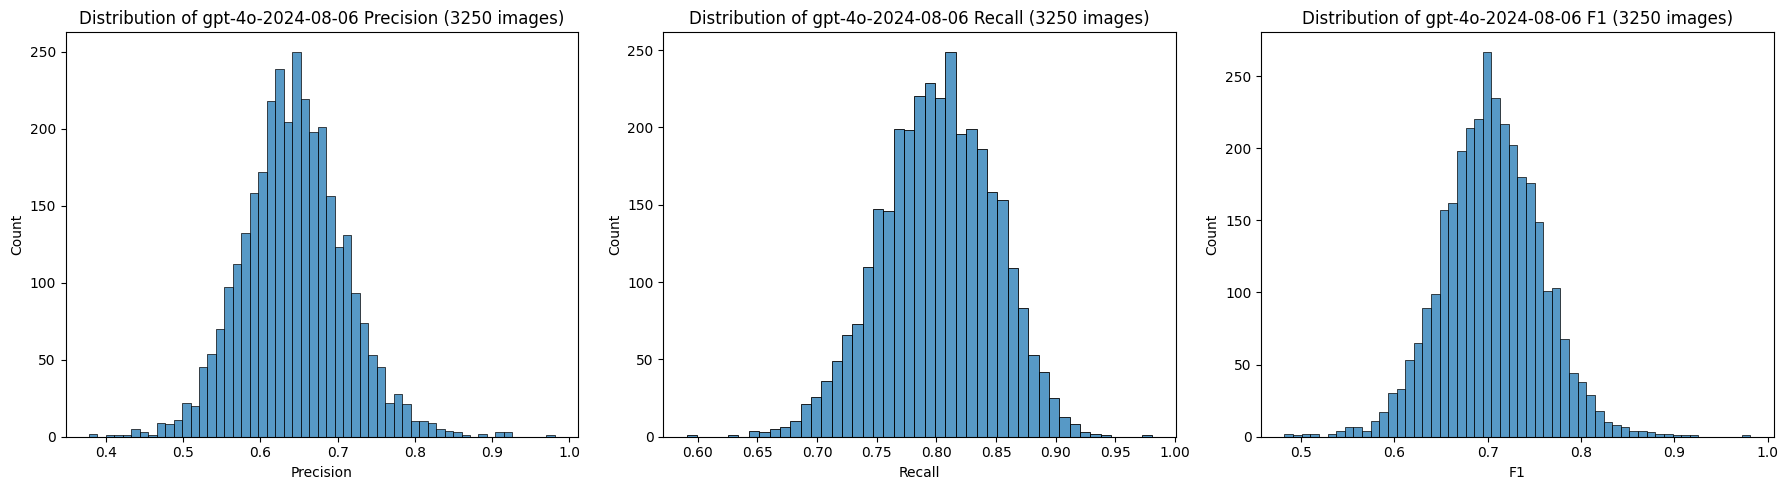

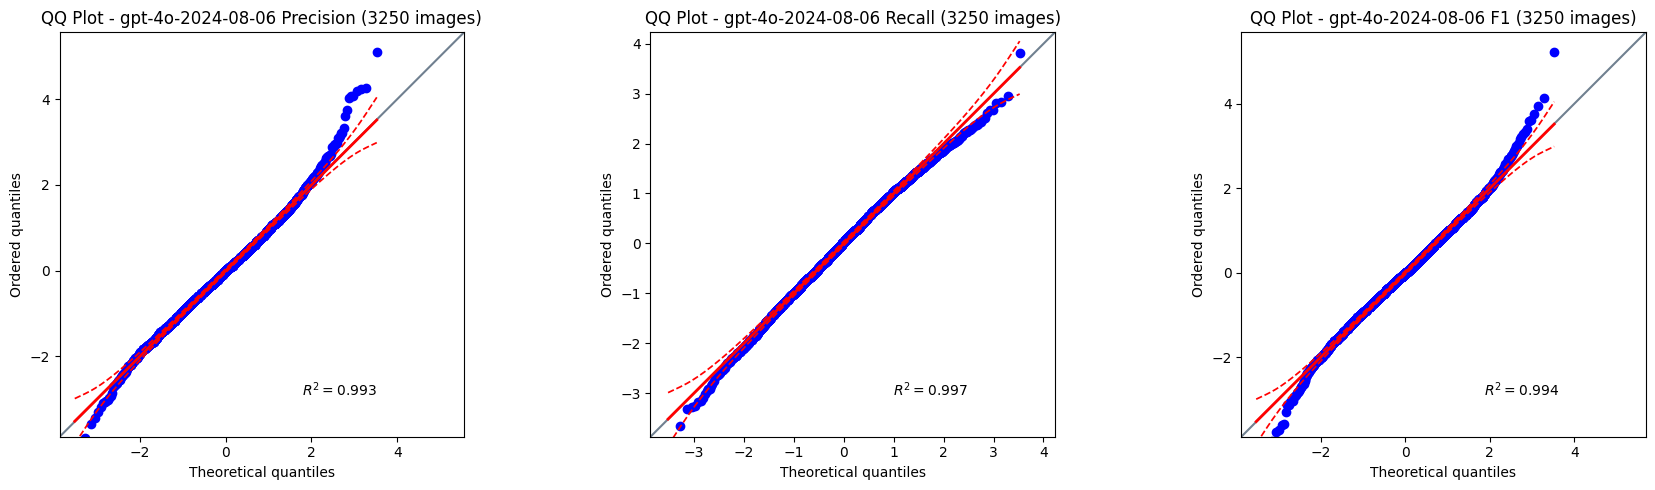

In [128]:
plot_model_distributions(
    high_quality_data_text_detected_formatted_df, "gpt-4o-2024-08-06"
)
plot_model_qq_plots(high_quality_data_text_detected_formatted_df, "gpt-4o-2024-08-06")

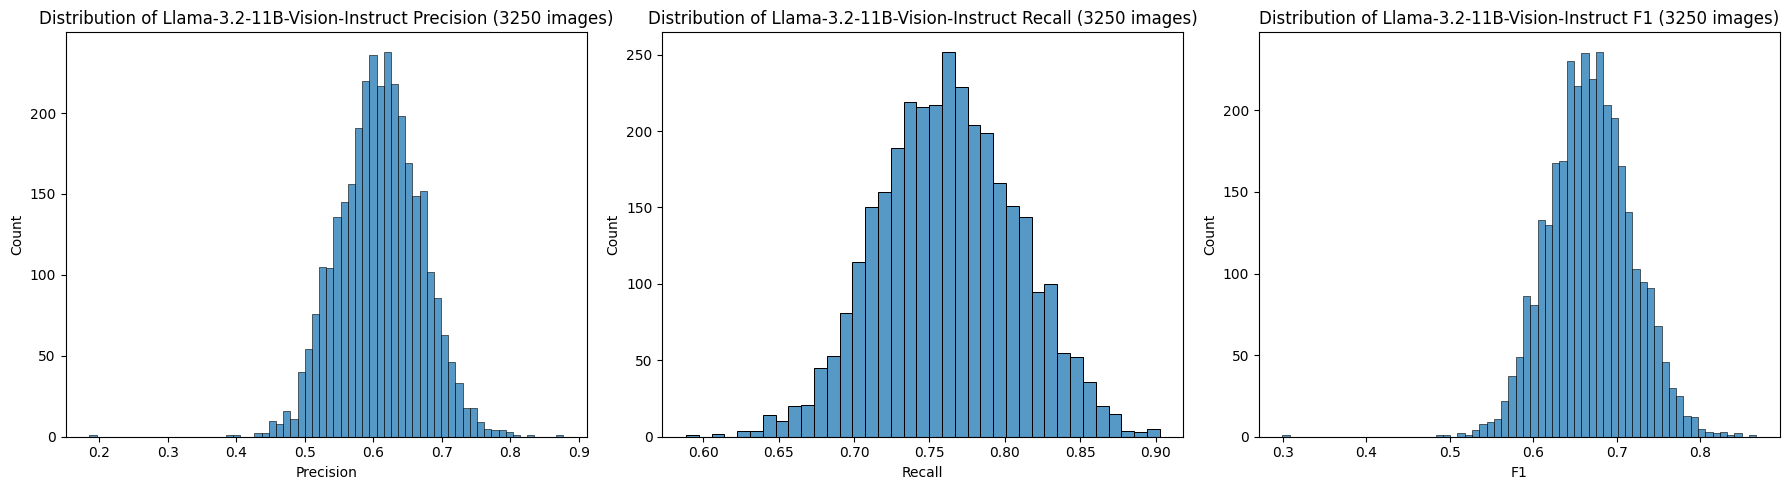

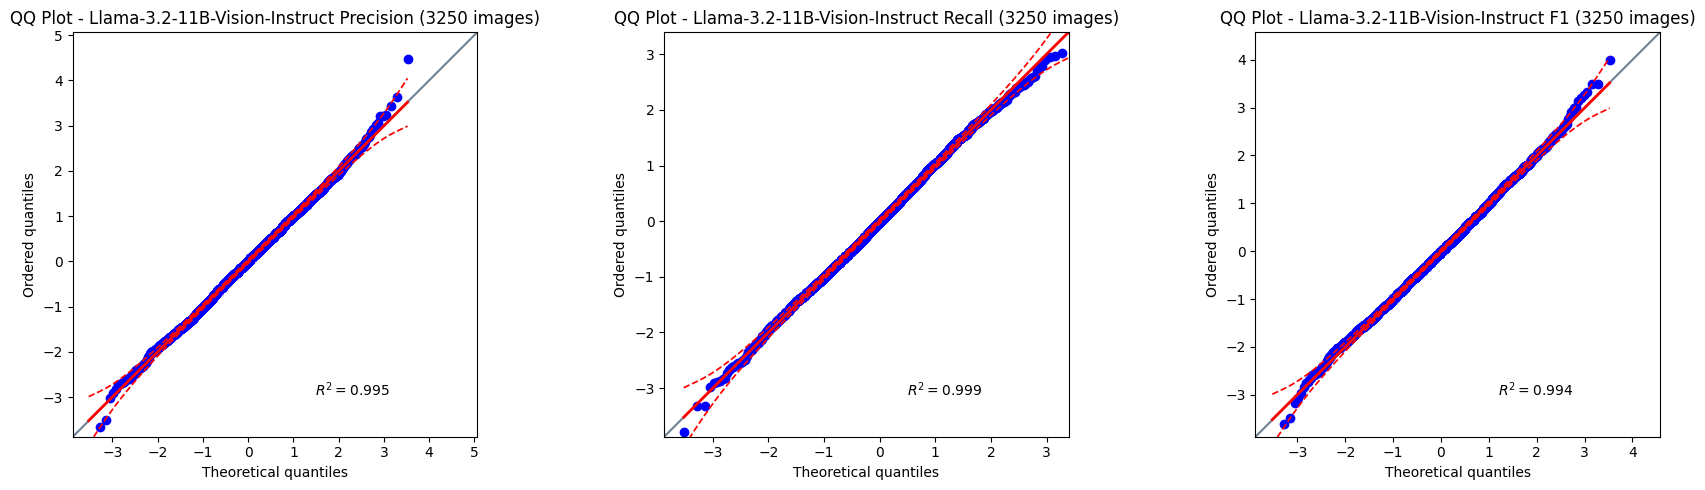

In [129]:
plot_model_distributions(
    high_quality_data_text_detected_formatted_df, "Llama-3.2-11B-Vision-Instruct"
)
plot_model_qq_plots(
    high_quality_data_text_detected_formatted_df, "Llama-3.2-11B-Vision-Instruct"
)

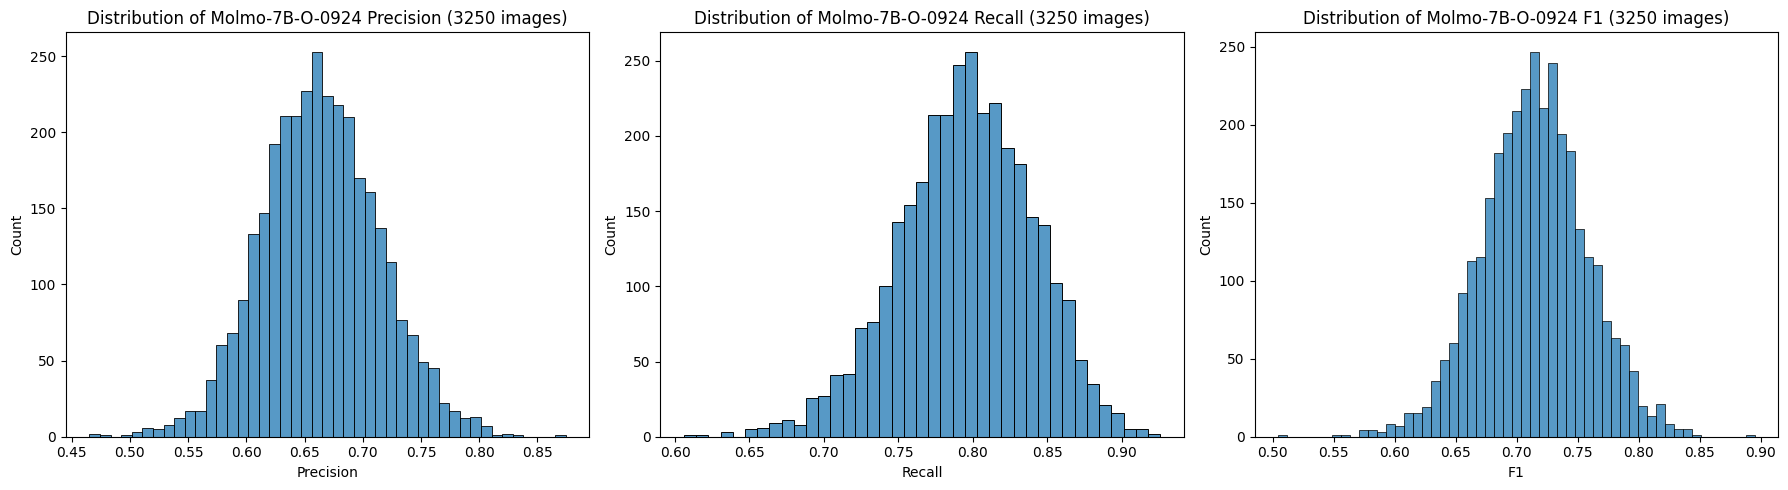

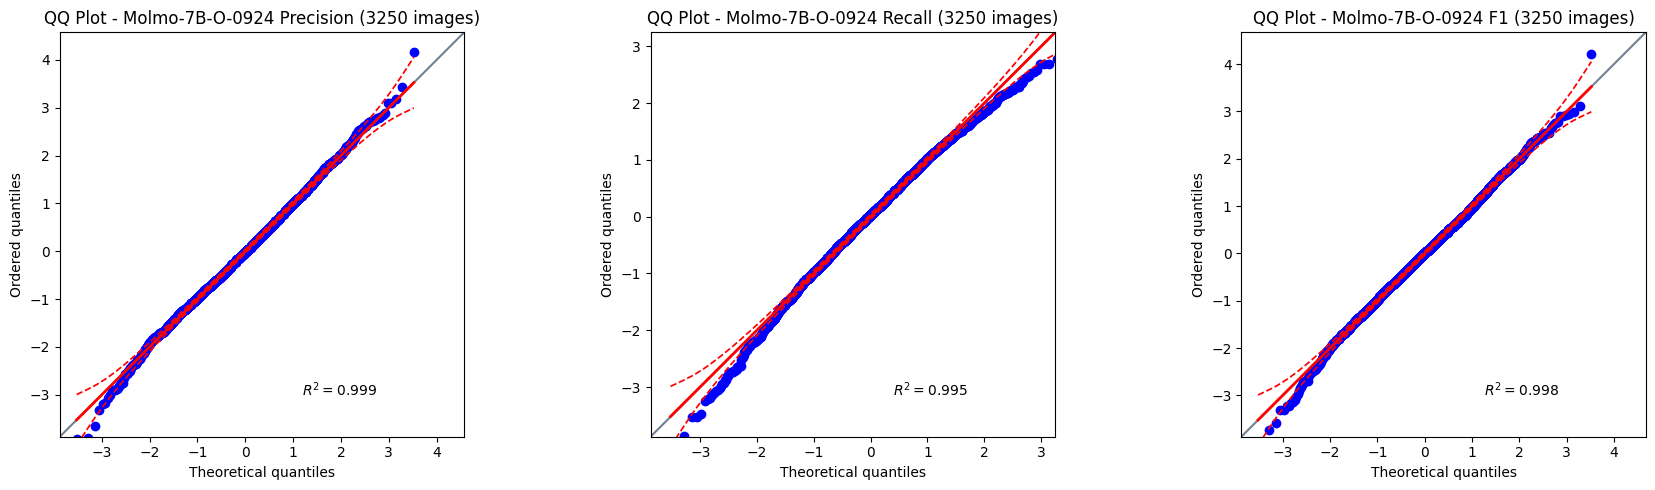

In [130]:
plot_model_distributions(
    high_quality_data_text_detected_formatted_df, "Molmo-7B-O-0924"
)
plot_model_qq_plots(high_quality_data_text_detected_formatted_df, "Molmo-7B-O-0924")

### Low-quality data

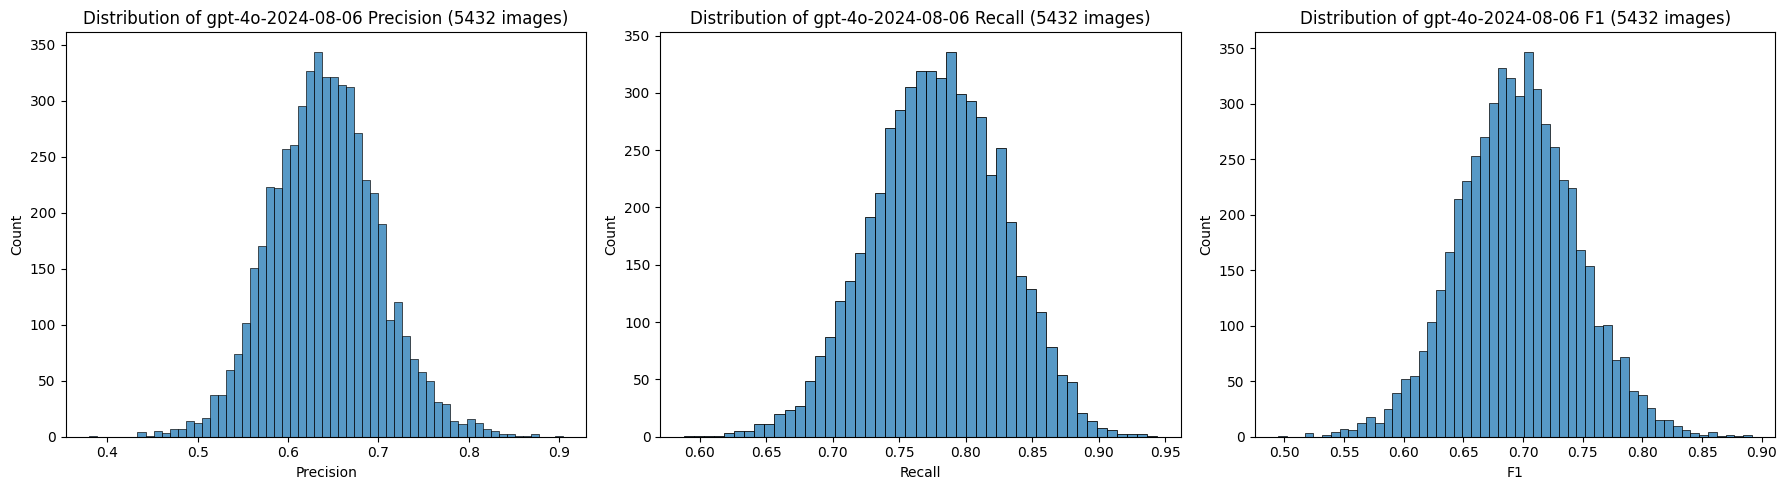

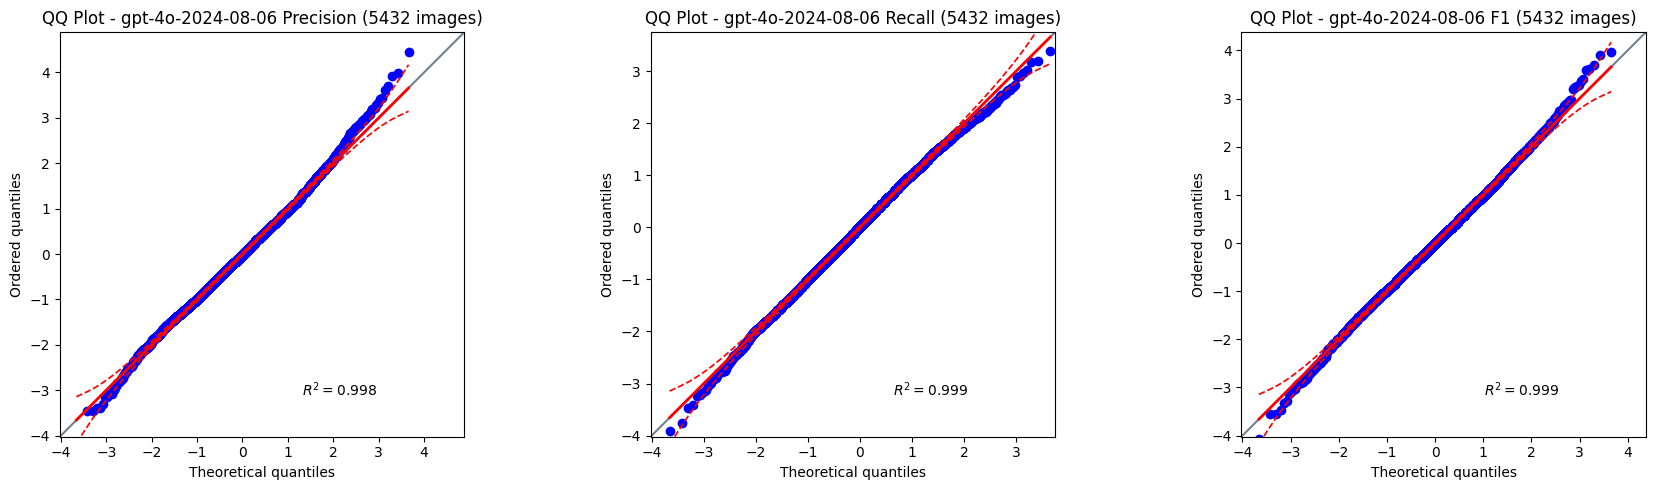

In [131]:
plot_model_distributions(low_quality_data_formatted_df, "gpt-4o-2024-08-06")
plot_model_qq_plots(low_quality_data_formatted_df, "gpt-4o-2024-08-06")

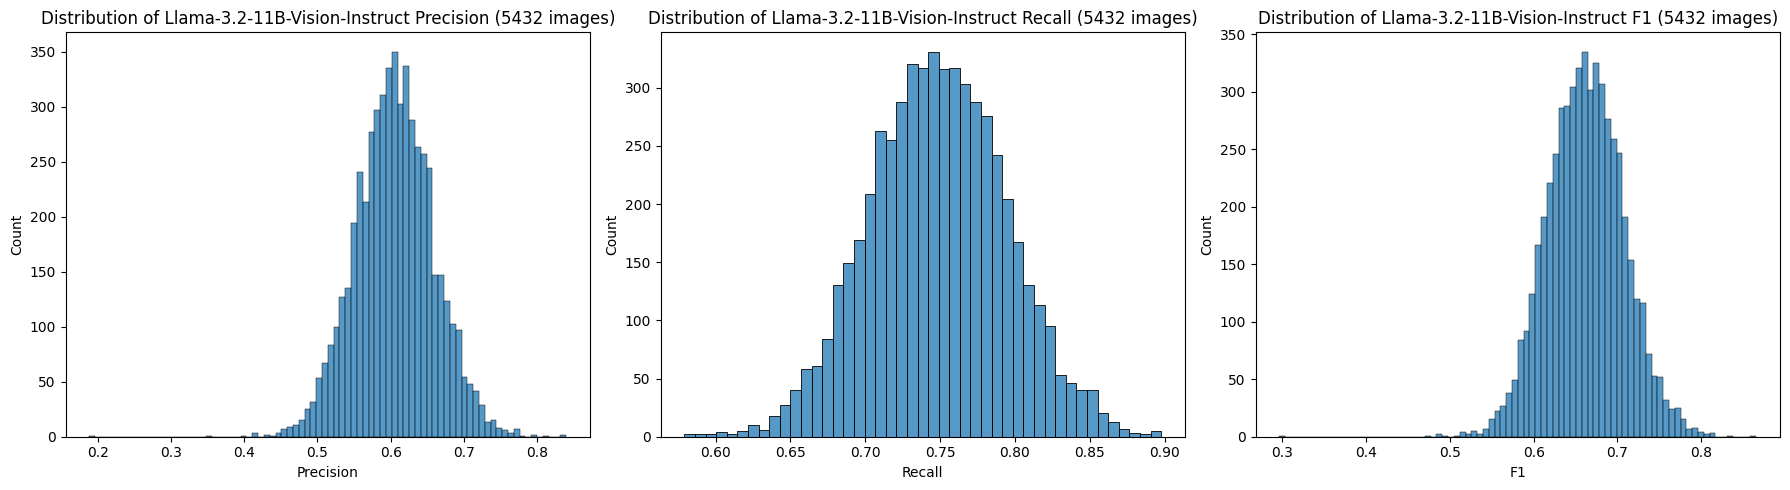

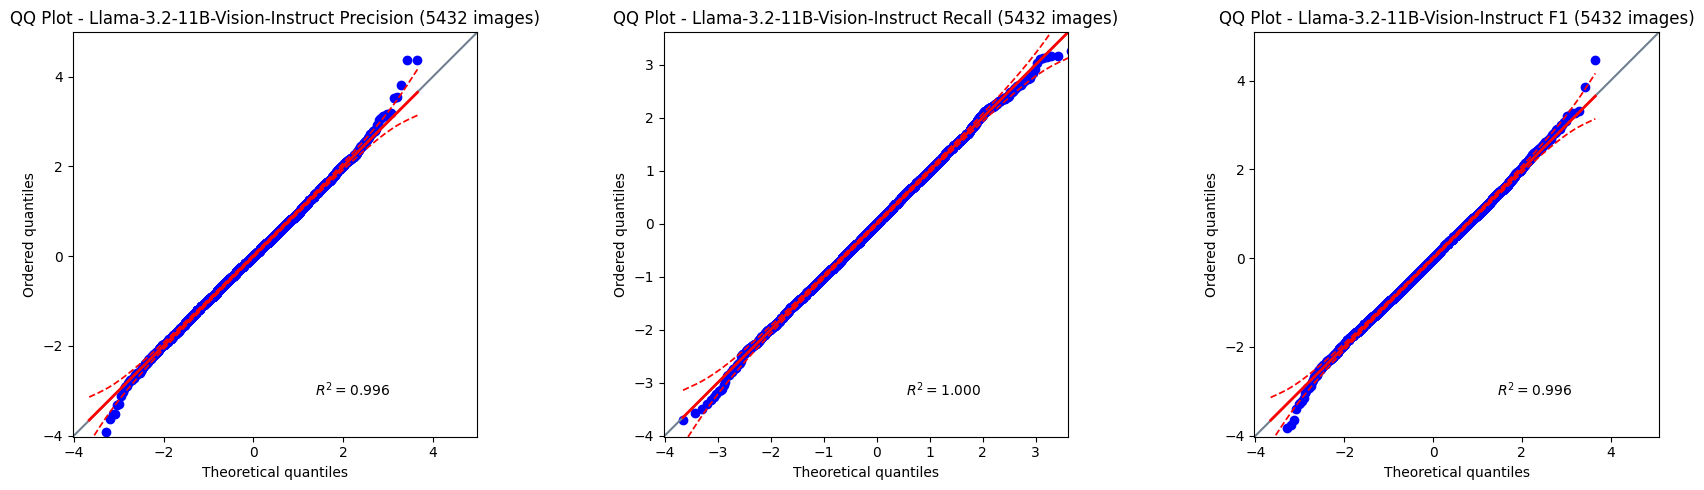

In [132]:
plot_model_distributions(low_quality_data_formatted_df, "Llama-3.2-11B-Vision-Instruct")
plot_model_qq_plots(low_quality_data_formatted_df, "Llama-3.2-11B-Vision-Instruct")

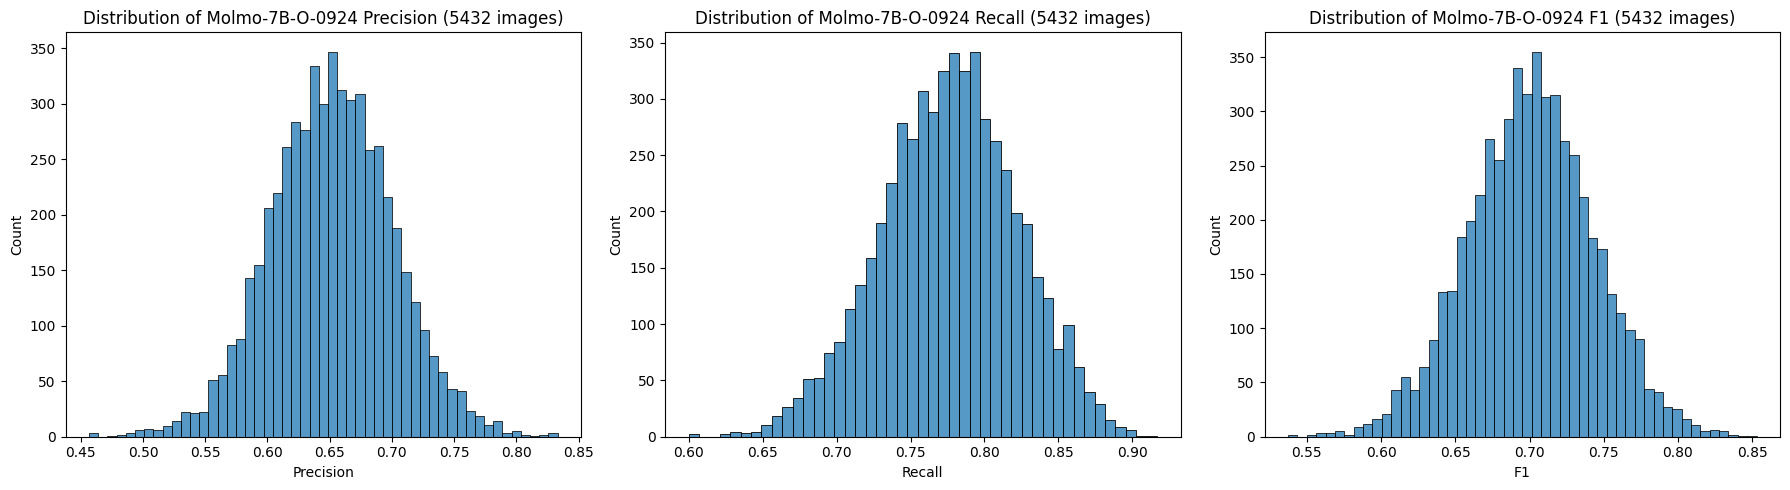

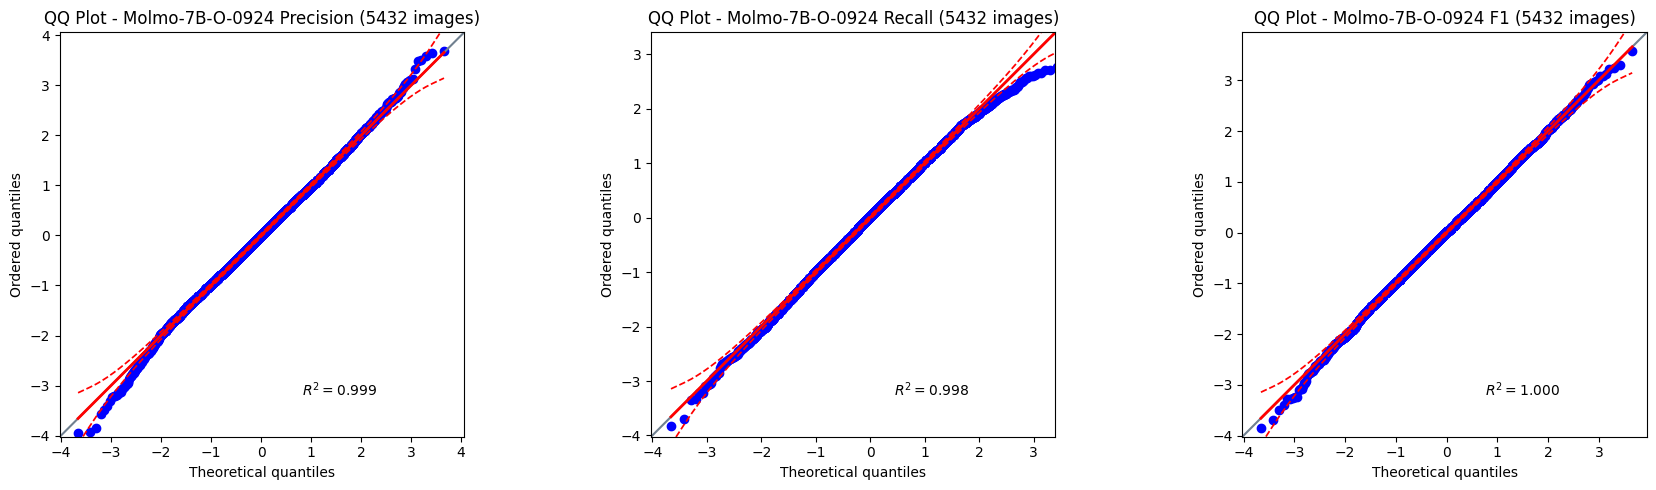

In [133]:
plot_model_distributions(low_quality_data_formatted_df, "Molmo-7B-O-0924")
plot_model_qq_plots(low_quality_data_formatted_df, "Molmo-7B-O-0924")

## Save data to csv to do statistical testing in R

In [134]:
# save high-quality image data
os.makedirs("./intermediate-data", exist_ok=True)
high_quality_data_text_detected_df.to_csv(
    "./intermediate-data/study1_high-quality-data-for-statistical-testing.csv",
    index=False,
)
# save low-quality image data
low_quality_data_df.to_csv(
    "./intermediate-data/study1_low-quality-data-for-statistical-testing.csv",
    index=False,
)

In [137]:
high_quality_metrics_table

,Model,Avg. Precision,Avg. Recall,F1 of Avg. Precision and Recall
0,gpt-4o-2024-08-06,0.667570,0.804425,0.729636
1,Llama-3.2-11B-Vision-Instruct,0.628016,0.765700,0.690057
2,Molmo-7B-O-0924,0.672105,0.795696,0.728697


In [142]:
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["gpt-4o-2024-08-06_pbert"],
    low_quality_data_df["gpt-4o-2024-08-06_pbert"],
)
print(U1, p)

9016635.0 0.0933776076103117


In [152]:
import scipy.stats as stats

print("GPT-4o mann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["gpt-4o-2024-08-06_pbert"],
    low_quality_data_df["gpt-4o-2024-08-06_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["gpt-4o-2024-08-06_rbert"],
    low_quality_data_df["gpt-4o-2024-08-06_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

GPT-4o mann whitney tests
Precision -- U1: 9016635.0; p: 0.0933776076103117
Recall -- U1: 11064415.0; p: 3.2137077969633243e-87


In [155]:
print("Llama-3.2-11B-Vision-Instruct mann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["Llama-3.2-11B-Vision-Instruct_pbert"],
    low_quality_data_df["Llama-3.2-11B-Vision-Instruct_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["Llama-3.2-11B-Vision-Instruct_rbert"],
    low_quality_data_df["Llama-3.2-11B-Vision-Instruct_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

Llama-3.2-11B-Vision-Instruct mann whitney tests
Precision -- U1: 9191152.0; p: 0.0012732969877192759
Recall -- U1: 10296244.0; p: 1.2308356304933309e-38


In [156]:
print("Molmo-7B-O-0924 mann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["Molmo-7B-O-0924_pbert"],
    low_quality_data_df["Molmo-7B-O-0924_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["Molmo-7B-O-0924_rbert"],
    low_quality_data_df["Molmo-7B-O-0924_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

Molmo-7B-O-0924 mann whitney tests
Precision -- U1: 10000764.0; p: 2.895692499498222e-25
Recall -- U1: 10907828.0; p: 1.0782510543861401e-75


In [157]:
import scipy.stats as stats

print("GPT-4o vs Llamamann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["gpt-4o-2024-08-06_pbert"],
    high_quality_data_text_detected_df["Llama-3.2-11B-Vision-Instruct_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_df["gpt-4o-2024-08-06_rbert"],
    low_quality_data_df["gpt-4o-2024-08-06_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

GPT-4o vs Llamamann whitney tests
Precision -- U1: 6858680.5; p: 1.4334172391003401e-96
Recall -- U1: 11064415.0; p: 3.2137077969633243e-87


In [ ]:
high_quality_data_text_detected_formatted_df.describe()

,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
count,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000
mean,0.105231,0.404923,0.288000,0.031692,0.109231,0.078154,0.089231,0.042154,4.106769,0.643554,0.800787,0.704252,0.609580,0.762360,0.668444,0.663611,0.795021,0.714215
std,0.337468,0.490953,0.452901,0.175207,0.311977,0.268455,0.285120,0.211420,0.795871,0.066155,0.047267,0.053069,0.059691,0.045968,0.049710,0.050536,0.045268,0.042863
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.377768,0.590687,0.482610,0.185612,0.588535,0.299371,0.465246,0.605974,0.504625
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.601162,0.768982,0.669719,0.570178,0.730620,0.635460,0.629645,0.765785,0.686291
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.643301,0.801816,0.703348,0.609535,0.761916,0.667669,0.662759,0.796651,0.714499
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.683740,0.834582,0.738511,0.648833,0.794012,0.700881,0.697012,0.826814,0.741494
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5.000000,0.981098,0.981098,0.981098,0.877149,0.902690,0.867341,0.874315,0.925887,0.894957


In [160]:
low_quality_data_formatted_df.describe()

,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
count,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000
mean,0.401878,2.992084,2.569035,0.194035,1.229934,0.239138,0.257916,0.061119,0.393594,0.641044,0.778913,0.695465,0.605596,0.748513,0.662073,0.651560,0.776088,0.700929
std,0.641317,1.606391,1.912855,0.633777,1.644742,0.621880,0.687857,0.250100,0.488591,0.059299,0.048774,0.049390,0.053403,0.045773,0.045581,0.049348,0.045998,0.042558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.380150,0.588031,0.494887,0.188914,0.579140,0.296731,0.456712,0.599909,0.537292
25%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600734,0.745946,0.662519,0.570595,0.716963,0.631123,0.618581,0.745012,0.672686
50%,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.639908,0.779609,0.695287,0.605812,0.748398,0.661796,0.651761,0.777475,0.701383
75%,1.000000,4.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.679221,0.813184,0.727825,0.640729,0.779568,0.692780,0.684615,0.807785,0.728602
max,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000,0.904240,0.944002,0.891708,0.839433,0.897767,0.865528,0.833079,0.916756,0.852978


## Let's look at just the LFA Data

In [195]:
low_quality_data_formatted_df.describe()

,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
count,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000,5432.000000
mean,0.401878,2.992084,2.569035,0.194035,1.229934,0.239138,0.257916,0.061119,0.393594,0.641044,0.778913,0.695465,0.605596,0.748513,0.662073,0.651560,0.776088,0.700929
std,0.641317,1.606391,1.912855,0.633777,1.644742,0.621880,0.687857,0.250100,0.488591,0.059299,0.048774,0.049390,0.053403,0.045773,0.045581,0.049348,0.045998,0.042558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.380150,0.588031,0.494887,0.188914,0.579140,0.296731,0.456712,0.599909,0.537292
25%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600734,0.745946,0.662519,0.570595,0.716963,0.631123,0.618581,0.745012,0.672686
50%,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.639908,0.779609,0.695287,0.605812,0.748398,0.661796,0.651761,0.777475,0.701383
75%,1.000000,4.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.679221,0.813184,0.727825,0.640729,0.779568,0.692780,0.684615,0.807785,0.728602
max,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000,0.904240,0.944002,0.891708,0.839433,0.897767,0.865528,0.833079,0.916756,0.852978


In [190]:
low_quality_data_lfa_df.describe()

,answerable,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.610000,0.370000,2.820000,2.650000,0.310000,1.280000,0.340000,0.210000,0.020000,0.440000,0.648113,0.778243,0.698162,0.604249,0.744328,0.659912,0.646001,0.771932,0.695269
std,0.490207,0.613896,1.578773,1.914195,1.021931,1.758558,0.855405,0.555869,0.140705,0.498888,0.066804,0.049338,0.052604,0.048174,0.048112,0.043326,0.049272,0.045460,0.041764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.458438,0.653480,0.554724,0.477533,0.643112,0.565807,0.492350,0.652755,0.561318
25%,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.601101,0.744991,0.661416,0.578176,0.709686,0.630739,0.613742,0.746750,0.665589
50%,1.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.646413,0.776212,0.699173,0.606739,0.744314,0.664528,0.648401,0.780416,0.695954
75%,1.000000,1.000000,4.000000,4.000000,0.000000,2.250000,0.000000,0.000000,0.000000,1.000000,0.680695,0.816748,0.737194,0.640259,0.780912,0.696040,0.688554,0.805391,0.724619
max,1.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000,1.000000,0.816963,0.899894,0.818954,0.692634,0.853355,0.750316,0.748357,0.879849,0.782966


In [ ]:
high_quality_data_text_detected_lfa_df.describe()

,answerable,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt-4o-2024-08-06_pbert,gpt-4o-2024-08-06_rbert,gpt-4o-2024-08-06_fbert,Llama-3.2-11B-Vision-Instruct_pbert,Llama-3.2-11B-Vision-Instruct_rbert,Llama-3.2-11B-Vision-Instruct_fbert,Molmo-7B-O-0924_pbert,Molmo-7B-O-0924_rbert,Molmo-7B-O-0924_fbert
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.728571,0.042857,0.371429,0.300000,0.071429,0.185714,0.100000,0.100000,0.042857,4.057143,0.645356,0.798664,0.703941,0.615902,0.766461,0.675671,0.655301,0.788926,0.707443
std,0.447907,0.203997,0.486675,0.461566,0.259399,0.391684,0.302166,0.302166,0.203997,0.849309,0.059540,0.038698,0.045072,0.058145,0.037887,0.046837,0.051390,0.041769,0.044930
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.533425,0.729213,0.625456,0.441369,0.689682,0.540223,0.573004,0.675789,0.612531
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.605110,0.766621,0.677810,0.583651,0.740836,0.646263,0.620578,0.769667,0.677445
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.639226,0.798503,0.696310,0.608207,0.763374,0.673621,0.645016,0.794943,0.698531
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.679738,0.826485,0.726552,0.643884,0.789202,0.704790,0.689377,0.817106,0.735206
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.808970,0.905358,0.820882,0.802897,0.852302,0.795993,0.804484,0.910025,0.842070


In [194]:
print("gpt-4o-2024-08-06 mann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_lfa_df["gpt-4o-2024-08-06_pbert"],
    low_quality_data_lfa_df["gpt-4o-2024-08-06_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_lfa_df["gpt-4o-2024-08-06_rbert"],
    low_quality_data_lfa_df["gpt-4o-2024-08-06_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

gpt-4o-2024-08-06 mann whitney tests
Precision -- U1: 3411.0; p: 0.779314816777769
Recall -- U1: 4313.0; p: 0.010094702936669791


In [193]:
print("Llama-3.2-11B-Vision-Instruct mann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_lfa_df["Llama-3.2-11B-Vision-Instruct_pbert"],
    low_quality_data_lfa_df["Llama-3.2-11B-Vision-Instruct_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_lfa_df["Llama-3.2-11B-Vision-Instruct_rbert"],
    low_quality_data_lfa_df["Llama-3.2-11B-Vision-Instruct_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

Llama-3.2-11B-Vision-Instruct mann whitney tests
Precision -- U1: 3842.0; p: 0.27957691490817815
Recall -- U1: 4419.0; p: 0.003635279285057786


In [192]:
print("Molmo-7B-O-0924 mann whitney tests")
U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_lfa_df["Molmo-7B-O-0924_pbert"],
    low_quality_data_lfa_df["Molmo-7B-O-0924_pbert"],
)

print(f"Precision -- U1: {U1}; p: {p}")

U1, p = stats.mannwhitneyu(
    high_quality_data_text_detected_lfa_df["Molmo-7B-O-0924_rbert"],
    low_quality_data_lfa_df["Molmo-7B-O-0924_rbert"],
)
print(f"Recall -- U1: {U1}; p: {p}")

Molmo-7B-O-0924 mann whitney tests
Precision -- U1: 3675.0; p: 0.5805999990311048
Recall -- U1: 4293.0; p: 0.012099002810111828
